In [2]:
# import libraries
import pandas as pd
import time
import requests
import json
from datetime import datetime
import os
import math
import numpy as np

# visualization stuff
import matplotlib.pyplot as plt
import hvplot.pandas

# import bus tacker api key
from config import bus_tracker_api_key as api_key

## Getting route information

In [33]:
# create base_url
base_url = "http://www.ctabustracker.com/bustime/api/v2/getroutes"

# create params for API call
params = {
    "key": api_key,
    "format": "json"
}

In [39]:
# make request and print response
route_info = requests.get(base_url, params=params).json()

# save route numbers and information to csv for safe keeping
routes = pd.DataFrame(route_info["bustime-response"]["routes"])
routes.rename(
    columns={
        "rt": "id",
        "rtnm": "name",
        "rtclr": "color"

    },
    inplace=True
)
routes.head()
routes.drop(columns="rtdd").to_csv("output/route_info.csv")

   id                       name    color rtdd
0   1  Bronzeville/Union Station  #336633    1
1   2          Hyde Park Express  #993366    2
2   3                 King Drive  #009900    3
3   4              Cottage Grove  #cc3300    4
4  X4      Cottage Grove Express  #006666   X4


## Tracking individual buses from each route

In [3]:
# create function that returns a dictionary that contains one bus from every currently active route
def get_active_bus_for_each_route():
    # load route information DataFame
    route_info = pd.read_csv("output/route_info.csv")

    # create base url
    base_url =  "http://www.ctabustracker.com/bustime/api/v2/getvehicles"

    # create params for API call
    params = {
        "key": api_key,
        "format": "json",
    }

    # create empty dictionary of buses to track for an hour, including what line they are from
    buses_to_track = {}

    # get the id of one bus from each hour, add it to the corresponding 
    for i in route_info["id"]:
        params["rt"] = i
        response = requests.get(base_url, params=params).json()
        try:
            buses_to_track[i] = response["bustime-response"]["vehicle"][0]["vid"]
        except KeyError:
            pass
    return buses_to_track
        


## Run this code multiple times at various points of the week to collect data on each route

In [ ]:
# get current date and time. format it
now = datetime.now()
now_formatted = f"{now.month}-{now.day}-{now.year}_{now.hour}-{'0' + str(now.minute) if len(str(now.minute)) == 1 else now.minute}"

# get one currently active bus for each route
current_buses = get_active_bus_for_each_route()

# create empty list for storing bus data
bus_data = []

# create base url and starting params
base_url =  "http://www.ctabustracker.com/bustime/api/v2/getvehicles"
params = {
    "key": api_key,
    "format": "json",
    }

# iterate over every bus in bus_data, making an API call every minute for an hour and extracting its current latitude and longitude
iterations = 60

# print starting message to logger
print("Beginning data bus tracking...")

for i in range(iterations):
    # print message for each iteration
    print(f"Beginning iteration #{i+1}")
    for route, vehicle_id in current_buses.items():
        # update params for this particular bus
        params["vid"] = vehicle_id
        
        # make api call and convert response to json
        response = requests.get(base_url, params=params).json()

        # use try-except block to handle response
        try:
            # append buses current latitdue and longitude to bus_data list
            now = datetime.now()
            bus_data.append({
                        "route": route,
                        "hour": now.hour,
                        "minute": now.minute,
                        "lat": response["bustime-response"]["vehicle"][0]["lat"],
                        "lon": response["bustime-response"]["vehicle"][0]["lon"]
                        })
            print(f"data found for vehicle {vehicle_id}")
            
        except KeyError:
            print(f"Vehicle {vehicle_id} not found. Skipping.")
    # wait 60 seconds before making another API call for each bus
    time.sleep(60)

# convert bus_data to DataFrame
bus_data_df = pd.DataFrame(bus_data)
bus_data_df["year"] = now.year
bus_data_df["month"] = now.month
bus_data_df["day"] = now.day

# save bus data to csv file in the output folder
bus_data_df.to_csv(f"output/bus_locations/{now_formatted}.csv", index=False)


## Cleaning and Preparing Data

In [3]:
# iterate over all files in output/bus_locations, concatenate them all together
# help iterating over every directory from https://www.geeksforgeeks.org/how-to-iterate-over-files-in-directory-using-python/#
df = pd.DataFrame()

# assign directory
directory = "output/bus_locations"

# iterate over files in directory and concatenate them to current DataFrame
for file in os.listdir(directory):
    f = os.path.join(directory, file)
    temp_df = pd.read_csv(f)
    df = pd.concat([df, temp_df])

df.head()
print(df.shape)


(23091, 8)


In [4]:
# merge df with route information that contains each route's color
route_info_df = pd.read_csv("output/route_info.csv")
route_info_df.rename(columns={
    "id": "route"
}, inplace=True)

df = pd.merge(df, route_info_df[["route", "name", "color"]], how="left", on=["route"])
df.head()

,route,hour,minute,lat,lon,year,month,day,name,color
0,3,13,39,41.720712,-87.623622,2024,8,10,King Drive,#009900
1,4,13,39,41.725163,-87.604492,2024,8,10,Cottage Grove,#cc3300
2,6,13,39,41.873089,-87.627128,2024,8,10,Jackson Park Express,#ff0066
3,8,13,39,41.846941,-87.647551,2024,8,10,Halsted,#ff00ff
4,8A,13,39,41.751057,-87.627609,2024,8,10,South Halsted,#66cc66


In [5]:
# convert year, month, and day columns all to one single datetime column
# https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
df["date"] = pd.to_datetime(df[["year", "month", "day", "hour", "minute"]])

# drop year, month, and day columns
df.drop(columns=["year", "month", "day", "hour", "minute"], inplace=True)
df.head()

,route,lat,lon,name,color,date
0,3,41.720712,-87.623622,King Drive,#009900,2024-08-10 13:39:00
1,4,41.725163,-87.604492,Cottage Grove,#cc3300,2024-08-10 13:39:00
2,6,41.873089,-87.627128,Jackson Park Express,#ff0066,2024-08-10 13:39:00
3,8,41.846941,-87.647551,Halsted,#ff00ff,2024-08-10 13:39:00
4,8A,41.751057,-87.627609,South Halsted,#66cc66,2024-08-10 13:39:00


In [6]:
# create the calculated row that contains the distance each bus travelled in its last time frame
# the roads in chicago run north-south and east-west for the most part, so calculate distance travelled as delta(x) + delta(y)

# create function for calculating haversine distance between two points on Earth
# https://www.omnicalculator.com/other/latitude-longitude-distance
def haversine_distance(p1, p2):
    R = 3958.8 # radius of Earth in miles

    # convert p1 and p2 to radians
    lat1, lon1 = math.radians(p1[0]), math.radians(p1[1])
    lat2, lon2 = math.radians(p2[0]), math.radians(p2[1])

    return 2*R * math.asin(math.sqrt(math.sin((lat2 - lat1) / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin((lon2 - lon1) / 2)**2)) 

# sort the df by route and then by date
df.sort_values(["route", "date"], inplace=True)
df.reset_index(drop=True, inplace=True)

# create empty list to become this calulated row
distance_travelled = []

# create dummy values for for loop
prev_route = None
prev_date = None
prev_lon = None
prev_lat = None

# iterate over the DataFrame
for index, row in df.iterrows():

    # if the current row's route and/or date values are not the same as the previous, update the previous and add a 0 to the Series,
    # since this is the beginning of a new route or day
    if row["route"] != prev_route or row["date"].day != prev_date.day:
        distance_travelled.append(0)
        prev_route = row["route"]
        prev_date = row["date"]
        
    else:
        # calculate the change in distance in both latitude and longitude. Do one calculation that only finds change in latitude and another that only does change in longitude and add them together
        distance = haversine_distance((row["lat"], prev_lon), (row["lat"], row["lon"])) + haversine_distance((prev_lat, row["lon"]), (row["lat"], row["lon"]))
        distance_travelled.append(distance)

    prev_lon = row["lon"]
    prev_lat = row["lat"]

# add distance travelled to the DataFrame
df["distance_travelled"] = distance_travelled
df.head()

,route,lat,lon,name,color,date,distance_travelled
0,1,41.878132,-87.632710,Bronzeville/Union Station,#336633,2024-08-08 07:15:00,0.000000
1,1,41.878139,-87.631346,Bronzeville/Union Station,#336633,2024-08-08 07:16:00,0.070732
2,1,41.878161,-87.629259,Bronzeville/Union Station,#336633,2024-08-08 07:17:00,0.108877
3,1,41.878167,-87.627916,Bronzeville/Union Station,#336633,2024-08-08 07:18:00,0.069449
4,1,41.878272,-87.625138,Bronzeville/Union Station,#336633,2024-08-08 07:20:00,0.150129


## Data Visualization

In [7]:
# create hvplot of each bus route on August 8th

# change date column to not contain hours or minutes so I can isolate August 8th
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.date.html
df["date"] = df["date"].dt.date

# create hvplot
# https://www.digitalocean.com/community/tutorials/python-string-to-datetime-strptime
map_plot = df.loc[df["date"] == datetime.strptime("2024-08-08", "%Y-%m-%d").date()].hvplot.points(
    "lon",
    "lat",
    geo=True,
    color="color",
    size="distance_travelled",
    frame_width = 700,
    frame_height = 500,
    legend=True,
    tiles=True
)
map_plot

c:\Users\Paul\anaconda3\envs\dev\lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [lon,lat]   (color,distance_travelled)

In [8]:
# create hvplot of each bus route on August 8th (without map in background)

map_plot = df.loc[df["date"] == datetime.strptime("2024-08-08", "%Y-%m-%d").date()].hvplot.points(
    "lon",
    "lat",
    geo=True,
    color="color",
    size="distance_travelled",
    frame_width = 700,
    frame_height = 500,
    legend=True,
)
map_plot

:Points   [lon,lat]   (color,distance_travelled)

In [9]:
# create a calculated speed column for each point in time
# with distance_travelled being in miles and a measurement being taken every minute or so, we can calculate mi/hr by multiplying the distance_travelled column by 60
df["mph"] = df["distance_travelled"] * 60
df.head()

,route,lat,lon,name,color,date,distance_travelled,mph
0,1,41.878132,-87.632710,Bronzeville/Union Station,#336633,2024-08-08,0.000000,0.000000
1,1,41.878139,-87.631346,Bronzeville/Union Station,#336633,2024-08-08,0.070732,4.243894
2,1,41.878161,-87.629259,Bronzeville/Union Station,#336633,2024-08-08,0.108877,6.532640
3,1,41.878167,-87.627916,Bronzeville/Union Station,#336633,2024-08-08,0.069449,4.166956
4,1,41.878272,-87.625138,Bronzeville/Union Station,#336633,2024-08-08,0.150129,9.007754


In [10]:
# group all of the data points together by route
grouped_routes_df = df.groupby(by="name")
route_means = grouped_routes_df["mph"].mean()
route_means.sort_values(inplace=True)

# reset index to maintain the name being a column
route_means = route_means.reset_index()

# merge route_means with df to get back route color
route_means = pd.merge(route_means, route_info_df[["name", "color"]], how="left", on="name")
route_means

,name,mph,color
0,Water Tower Express,4.650345,#99cc33
1,LaSalle,6.064802,#ff6600
2,Navy Pier,6.343431,#ff9999
3,Sedgwick,6.515226,#993366
4,Museum Campus,6.574582,#ff3333
...,...,...,...
119,South Shore Express,20.258446,#006666
120,Stockton/LaSalle Express,21.657907,#009900
121,Jeffery Jump,22.689597,#663399
122,U. of Chicago Hospitals Express,26.610665,#cc3300


In [11]:
route_means.tail()

,name,mph,color
119,South Shore Express,20.258446,#006666
120,Stockton/LaSalle Express,21.657907,#009900
121,Jeffery Jump,22.689597,#663399
122,U. of Chicago Hospitals Express,26.610665,#cc3300
123,69th-UPS Express,35.214654,#99cc33


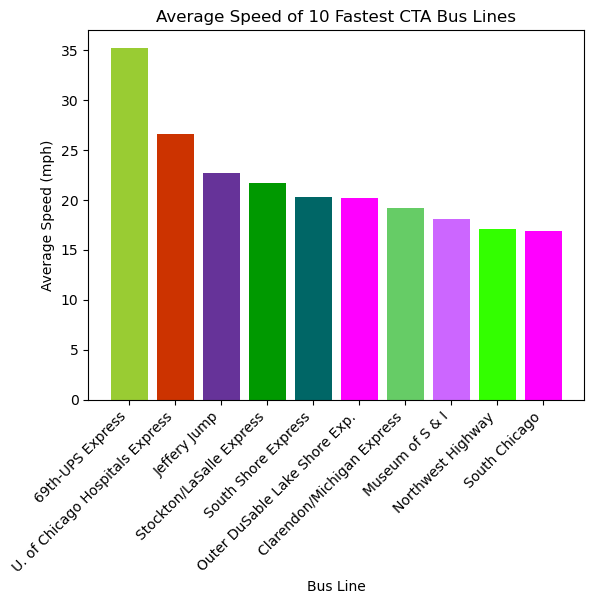

In [18]:
# create bar plot showing the average speeds for 10 fastest routes
data = route_means.tail(10)
# reverse data
# https://stackoverflow.com/questions/20444087/right-way-to-reverse-a-pandas-dataframe
data = data[::-1]

# plot data
plt.bar(data["name"], data["mph"], color=data["color"])

plt.title("Average Speed of 10 Fastest CTA Bus Lines")
plt.xlabel("Bus Line")
plt.ylabel("Average Speed (mph)")

plt.xticks([i for i in range(10)], labels=data["name"], rotation=45, ha="right")

# help with padding on savefig: https://stackoverflow.com/questions/6774086/how-to-adjust-padding-with-cutoff-or-overlapping-labels
plt.savefig("output/fastest_buses_bar.png", bbox_inches="tight")
plt.show()

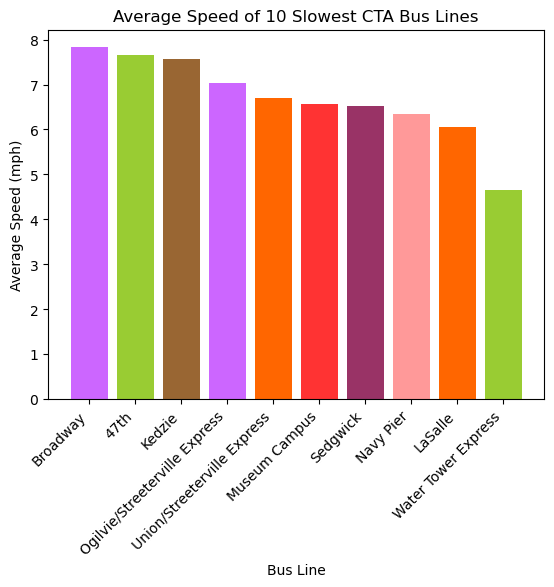

In [19]:
# create bar plot showing the average speeds for 10 slowest routes
data = route_means.head(10)

# reverse data
data = data[::-1]

# plot data
plt.bar(data["name"], data["mph"], color=data["color"])

plt.title("Average Speed of 10 Slowest CTA Bus Lines")
plt.xlabel("Bus Line")
plt.ylabel("Average Speed (mph)")

plt.xticks([i for i in range(10)], labels=data["name"], rotation=45, ha="right")

plt.savefig("output/slowest_buses_bar.png", bbox_inches="tight")
plt.show()

### Are Express Lines Actually Faster?

In [14]:
# load in route info
route_info = pd.read_csv("output/route_info.csv")

# create empty set to hold all express route names
express_routes = set()

# loop over all routes, extracting those that end with "Express" or "Exp."
for i in route_info["name"]:
    split_name = i.split(" ")
    if split_name[-1] == "Express" or split_name[-1] == "Exp.":
        express_routes.add(i)

# filtering route_means to only include express routes
# https://www.geeksforgeeks.org/ways-to-filter-pandas-dataframe-by-column-values/
express_route_means = route_means.loc[route_means["name"].isin(express_routes)]
express_route_means.head()

,name,mph,color
0,Water Tower Express,4.650345,#99cc33
5,Union/Streeterville Express,6.689712,#ff6600
6,Ogilvie/Streeterville Express,7.031530,#cc66ff
39,Inner Lake Shore/Michigan Exp.,9.631283,#666600
59,Stockton/Michigan Express,11.189448,#006666


In [15]:
# filtering route_means to only include non express routes
# https://www.geeksforgeeks.org/how-to-use-not-in-filter-in-pandas/
non_express_route_means = route_means.loc[~route_means["name"].isin(express_routes)]
non_express_route_means.head()

,name,mph,color
1,LaSalle,6.064802,#ff6600
2,Navy Pier,6.343431,#ff9999
3,Sedgwick,6.515226,#993366
4,Museum Campus,6.574582,#ff3333
7,Kedzie,7.577832,#996633


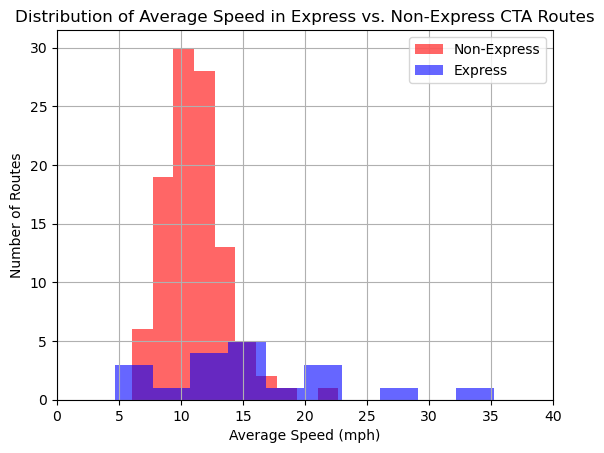

In [16]:
# plot histogram showing distributions of average speed for express and non-express routes
plt.hist(non_express_route_means["mph"], alpha=0.6, color="red")
plt.hist(express_route_means["mph"], alpha=0.6, color="blue")
plt.legend(["Non-Express", "Express"])
plt.grid()
plt.xlim(0, 40)
plt.xlabel("Average Speed (mph)")
plt.ylabel("Number of Routes")
plt.title("Distribution of Average Speed in Express vs. Non-Express CTA Routes")
plt.savefig("output/express_v_non_express_hist.png")
plt.show()

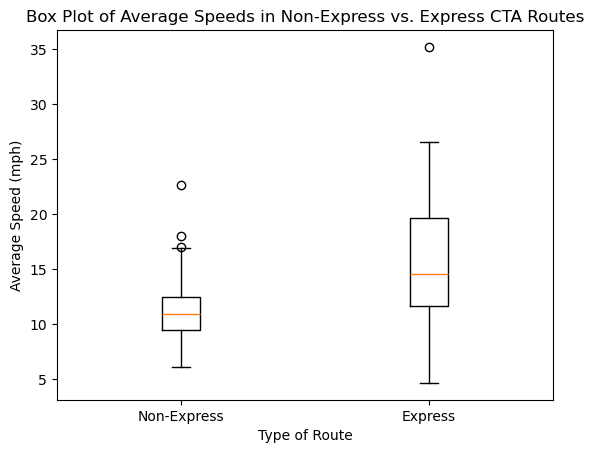

In [17]:
plt.boxplot([non_express_route_means["mph"], express_route_means["mph"]], labels=["Non-Express", "Express"])
plt.xlabel("Type of Route")
plt.ylabel("Average Speed (mph)")
plt.title("Box Plot of Average Speeds in Non-Express vs. Express CTA Routes")
plt.savefig("output/express_v_non_express_boxplot.png")
plt.show()